In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("generated_dataset.csv")
data['leak_status']=data['CR-corrosion defect']
data = data.rename(columns = {'CR-corrosion defect':"CRD"}, inplace=False)

data['leak_status']=data['leak_status'].astype('object')

data.loc[(data.CRD<0.150), 'leak_status']= 0
data.loc[(data.CRD>=0.150)&(data.CRD<0.200), 'leak_status']= 1
data.loc[(data.CRD>=0.200)&(data.CRD<0.250), 'leak_status']= 2
data.loc[(data.CRD>=0.250), 'leak_status']= 3
data = data.drop('CRD', axis=1)


data.head()

,Wellhead Temp. (C),Wellhead Press (psi),MMCFD- gas,BOPD (barrel of oil produced per day),BWPD (barrel of water produced per day),BSW - basic solid and water (%),CO2 mol. (%) @ 25 C & 1 Atm.,Gas Grav.,leak_status
0,53.35,1105.13,12.87,1378.93,2812.62,75.64,3.3628,0.7205,2
1,72.25,1026.31,3.42,1028.75,919.92,44.21,3.8679,0.8940,2
2,65.08,722.96,6.23,2017.92,1212.42,17.55,2.3552,0.7661,2
3,60.71,1557.23,11.71,558.22,1716.09,65.79,1.7253,0.7738,2
4,46.19,1304.42,8.58,1280.47,1929.22,37.45,1.8327,0.7611,2


In [40]:
# Filter the dataset to include only rows where a leak is detected (leak_status > 0)
data = data[data['leak_status'] > 0]
# Verify `leak_status` data type and value counts
data['leak_status'] = data['leak_status'].astype(int)
data['leak_status'].dtype, data['leak_status'].value_counts()

(dtype('int64'),
 leak_status
 2    5877
 1    2900
 3    1055
 Name: count, dtype: int64)

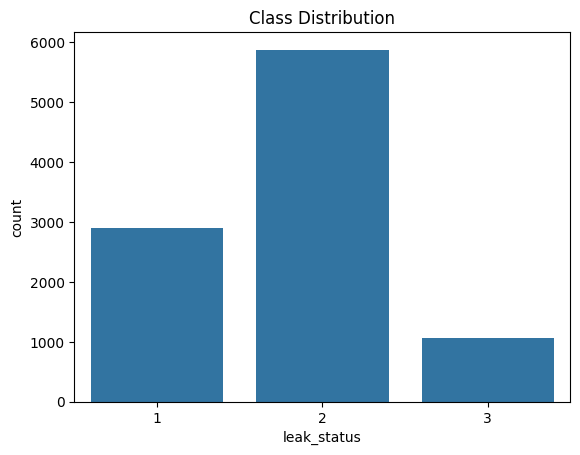

In [35]:
# Visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns


class_labels = ['Minor Leak', 'Moderate Leak', 'Severe Leak']

sns.countplot(x='leak_status', data=data)
plt.title('Class Distribution')
plt.show()

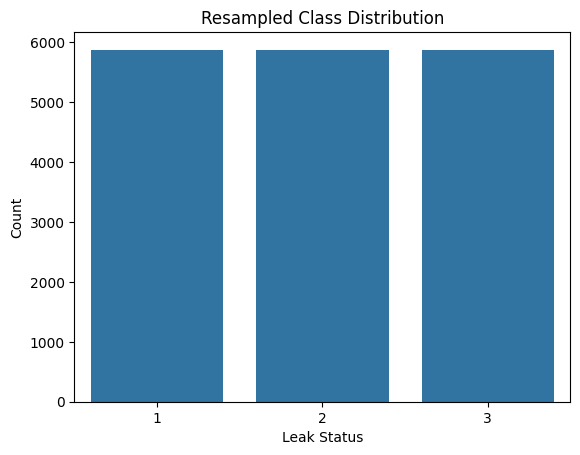

Leak Status
Moderate Leak    5877
Severe Leak      5877
Minor Leak       5877
Name: count, dtype: int64


In [41]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = data.drop('leak_status', axis=1)
y = data['leak_status']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Apply SMOTE to handle imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Visualize resampled class distribution
sns.countplot(x=y_resampled)
plt.title('Resampled Class Distribution')
plt.xlabel('Leak Status')
plt.ylabel('Count')
plt.show()

y_resampled_series = pd.Series(y_resampled, name='Leak Status')
print(y_resampled_series.value_counts().rename(index={i: class_labels[i-1] for i in y_resampled_series.unique()}))

In [43]:
from sklearn.model_selection import train_test_split

# Split into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Further split the training set into training and validation sets (80-20 split of the training set)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [45]:
# Set the parameters for GridSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

# Define kfold cross validtor
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 1, 0.1, 0.01],
    'kernel': ['rbf']
}

svm_model = SVC(probability=True)

# Initialize GridSearchCV with SVC
grid = GridSearchCV(estimator=svm_model, param_grid=param_grid, verbose=2, cv=kfold, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Print the best parameters and estimator
print("Best Parameters: ", grid.best_params_)
print("Best Estimator: ", grid.best_estimator_)
print("Best Score from Grid Search:", grid.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  34.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  35.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  36.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  36.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  36.4s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  36.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.2min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.3min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  40.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.3min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  41.3s
[CV] END .......................C=0.1, gamma=0.

In [47]:
from sklearn.metrics import classification_report, accuracy_score

"""
    Best Parameters:  {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
    Best Estimator:  SVC(C=100, gamma=0.1, probability=True)
    Best Score from Grid Search: 0.949127104956369
"""

# Use the best estimator to predict leak or no leak on the validation set
model = grid.best_estimator_
y_val_pred = model.predict(X_val)

# Accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# Evaluate the model on the validation set
print(classification_report(y_val, y_val_pred, target_names=class_labels))

Validation Accuracy: 0.9475363346331088
               precision    recall  f1-score   support

   Minor Leak       0.96      0.97      0.97       941
Moderate Leak       0.93      0.92      0.93       940
  Severe Leak       0.95      0.95      0.95       940

     accuracy                           0.95      2821
    macro avg       0.95      0.95      0.95      2821
 weighted avg       0.95      0.95      0.95      2821



Validation Accuracy: 0.9475363346331088
Validation ROC-AUC Score: 0.9925749082850365
Classification Report:
                precision    recall  f1-score   support

   Minor Leak       0.96      0.97      0.97       941
Moderate Leak       0.93      0.92      0.93       940
  Severe Leak       0.95      0.95      0.95       940

     accuracy                           0.95      2821
    macro avg       0.95      0.95      0.95      2821
 weighted avg       0.95      0.95      0.95      2821



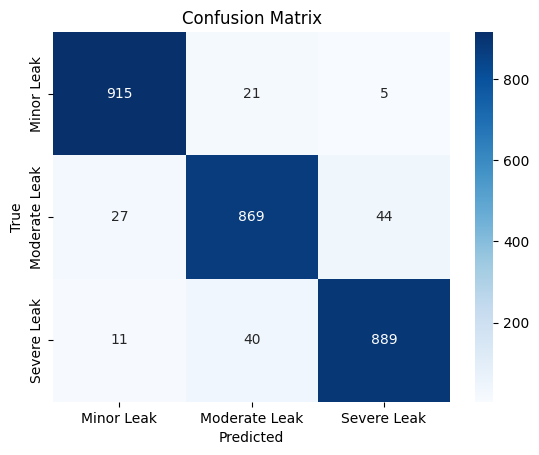

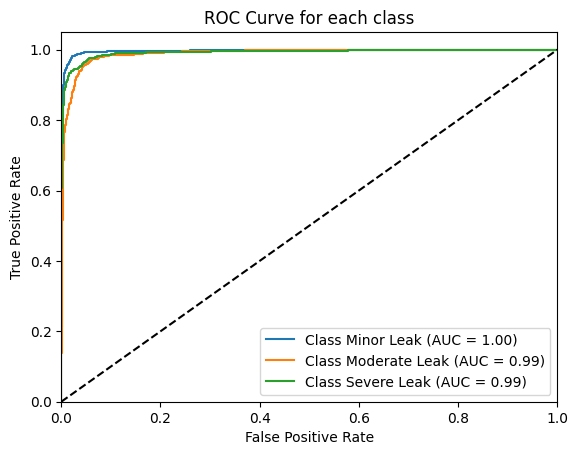

In [51]:
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize


# Predictions on the validation set
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)

# Accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# ROC-AUC Score
val_roc_auc = roc_auc_score(y_val, y_val_prob, multi_class='ovr')
print("Validation ROC-AUC Score:", val_roc_auc)

# Classification report with class labels
print("Classification Report:\n", classification_report(y_val, y_val_pred, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix with class labels
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Binarize the output for ROC curve computation
y_val_binarized = label_binarize(y_val, classes=np.unique(y_val))
n_classes = y_val_binarized.shape[1]

# ROC Curve for each class
plt.figure()
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_val_binarized[:, i], y_val_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc='lower right')
plt.show()

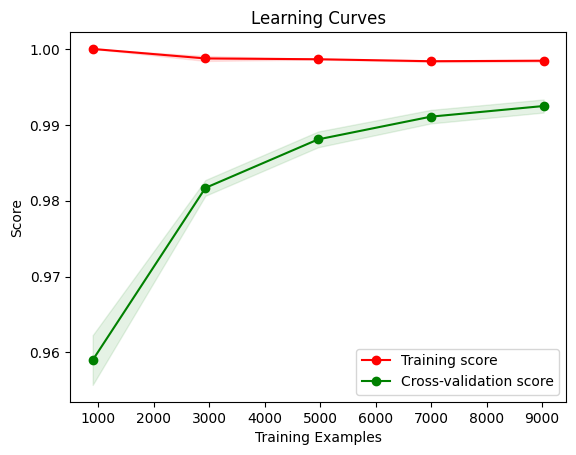

In [52]:
from sklearn.model_selection import learning_curve


# Learning curves
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5, scoring='roc_auc_ovr', n_jobs=-1)

# Calculate mean and standard deviation
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plot learning curves
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
plt.title('Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

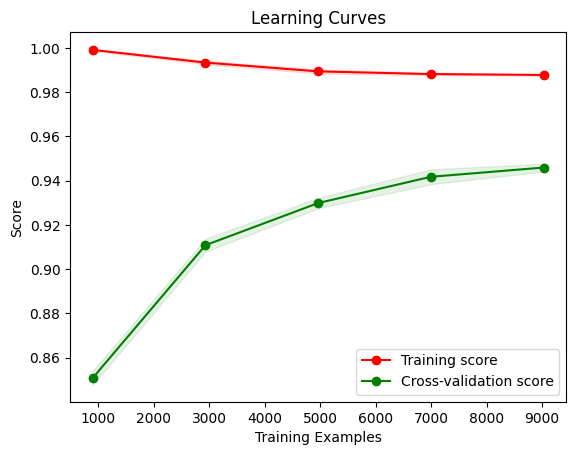

In [53]:

# Learning curves with scoring=accuracy
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# Calculate mean and standard deviation
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plot learning curves
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')
plt.title('Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

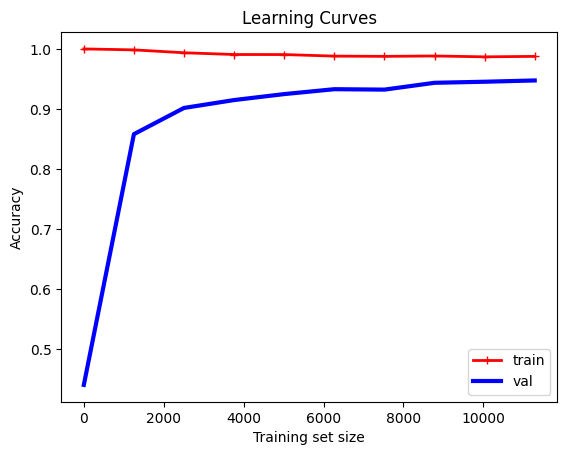

In [54]:
# Helper function to plot learning curves
def plot_learning_curves(model, X_train, y_train, X_val, y_val):
    train_errors, val_errors = [], []
    m_values = np.linspace(max(1, len(np.unique(y_train))), len(X_train), 10, dtype=int)
    for m in m_values:
        if len(np.unique(y_train[:m])) < 2:
            continue
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(accuracy_score(y_train[:m], y_train_predict))
        val_errors.append(accuracy_score(y_val, y_val_predict))
    
    plt.plot(m_values, train_errors, "r-+", linewidth=2, label="train")
    plt.plot(m_values, val_errors, "b-", linewidth=3, label="val")
    plt.legend()
    plt.xlabel('Training set size')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves')
    plt.show()

plot_learning_curves(model, X_train, y_train, X_val, y_val)

Test Accuracy: 0.9535015593989226
Confusion Matrix:
[[1154   19    2]
 [  39 1077   60]
 [  18   26 1132]]
Classification Report:
               precision    recall  f1-score   support

   Minor Leak       0.95      0.98      0.97      1175
Moderate Leak       0.96      0.92      0.94      1176
  Severe Leak       0.95      0.96      0.96      1176

     accuracy                           0.95      3527
    macro avg       0.95      0.95      0.95      3527
 weighted avg       0.95      0.95      0.95      3527



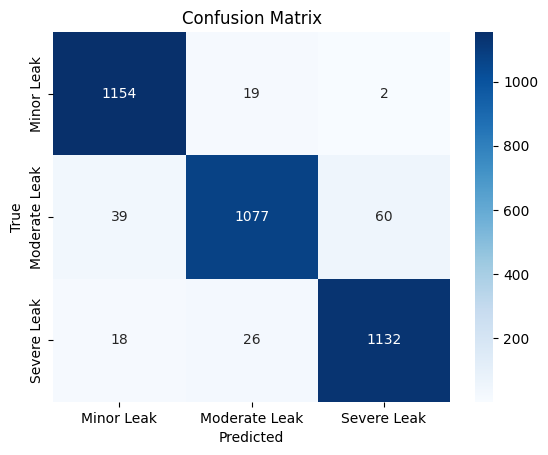

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test set
y_test_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=class_labels))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

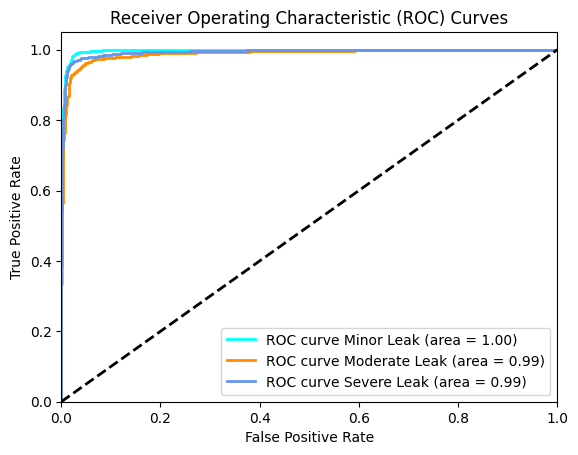

In [59]:
from itertools import cycle


# Binarize the output labels for ROC-AUC computation
y_test_bin = label_binarize(y_test, classes=[1,2,3])
n_classes = y_test_bin.shape[1]

# Compute the probabilities of each class
y_test_prob = model.predict_proba(X_test)

# Compute ROC curve and ROC-AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_test_prob[:, i], multi_class='ovr')

# Plotting ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

In [61]:
import pickle


with open('svm_leak_severity_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print(f"Trained model saved as svm_leak_severity_model.pkl")

Trained model saved as svm_leak_severity_model.pkl


In [62]:
# Load the trained model from the pkl file
with open('svm_leak_severity_model.pkl', 'rb') as file:
    severity_model = pickle.load(file)
    
# Load the trained model from the pkl file
with open('svm_leak_detection_model.pkl', 'rb') as file:
    leak_model = pickle.load(file)

print("Model loaded successfully.")

Model loaded successfully.


In [88]:
import pandas as pd

# Example case scenario
example_case = {
    'Wellhead Temp. (C)': 50.0,
    'Wellhead Press (psi)': 1450.0,
    'MMCFD- gas': 9.0,
    'BOPD (barrel of oil produced per day)': 460.0,
    'BWPD (barrel of water produced per day)': 220.0,
    'BSW - basic solid and water (%)': 5.5,
    'CO2 mol. (%) @ 25 C & 1 Atm.': 1.1,
    'Gas Grav.': 0.67,
}

labels = ['No Leak', 'Leak']

def format_status_prediction(prediction, probabilities, class_labels):
    prediction_int = int(prediction[0])
    predicted_status_str = f"Predicted status: {class_labels[prediction_int]}"
    prediction_probabilities_str = "Prediction probabilities:\n" + "\n".join(
        [f"{label}: {prob:.2%}" for label, prob in zip(class_labels, probabilities[0])]
    )
    return predicted_status_str, prediction_probabilities_str

def format_leak_prediction(prediction, probabilities, class_labels):
    prediction_int = int(prediction[0])
    predicted_status_str = f"Predicted status: {class_labels[prediction_int - 1]}"
    prediction_probabilities_str = "Prediction probabilities:\n" + "\n".join(
        [f"{label}: {prob:.2%}" for label, prob in zip(class_labels, probabilities[0])]
    )
    return predicted_status_str, prediction_probabilities_str

def predict_leak_status(example_case, scaler, model):
    # Convert the example case to a DataFrame
    example_df = pd.DataFrame([example_case])
    # Scale the features of the example case using the same scaler used for training
    example_scaled = scaler.transform(example_df)
    # Predict the leak status using the loaded model
    prediction = model.predict(example_scaled)
    prediction_proba = model.predict_proba(example_scaled)
    return prediction, prediction_proba

def predict_status(example_case, scaler, leak_model, severity_model, labels, class_labels):
    prediction, prediction_proba = predict_leak_status(example_case, scaler, leak_model)
    predicted_status_str, prediction_probabilities_str = format_status_prediction(prediction, prediction_proba, labels)
    


    if labels[int(prediction[0])] == 'Leak':
        prediction, prediction_proba = predict_leak_status(example_case, scaler, severity_model)
        predicted_status_str, prediction_probabilities_str = format_leak_prediction(prediction, prediction_proba, class_labels)

        print(predicted_status_str)
        print(prediction_probabilities_str)
    else:
        print(predicted_status_str)
        print(prediction_probabilities_str)

    print('Completed')


predict_status(example_case, scaler, leak_model, severity_model, labels, class_labels)


Predicted status: Moderate Leak
Prediction probabilities:
Minor Leak: 3.06%
Moderate Leak: 96.69%
Severe Leak: 0.25%
Completed
